# Konnektor - Building Ligand Networks

this is Konnektor, which you can use to construct different types of Networks.

In [1]:
import numpy as np
from rdkit import Chem

try:
    from kartograf import KartografAtomMapper, MappingRMSDScorer
except ModuleNotFoundError:
    !{sys.executable} -m pip install git+https://github.com/OpenFreeEnergy/kartograf.git
    from kartograf import KartografAtomMapper, MappingRMSDScorer


import logging
from kartograf.atom_mapper import logger
logger.setLevel(logging.ERROR)


/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


In [41]:
from konnektor.utils.toy_data import build_random_dataset

components, mapper, scorer = build_random_dataset(n_compounds=25)

from konnektor.visualization import draw_ligand_network


# Radial Network Layout

In [42]:
from konnektor.network_planners import StarNetworkGenerator
ligand_network_planner = StarNetworkGenerator(mapper=mapper, scorer=scorer)

In [43]:
radial_network = ligand_network_planner(components)
radial_network.name="Star Network"
radial_network

<LigandNetwork-28543e81b992dbfcf6be38a8c902a9ff>

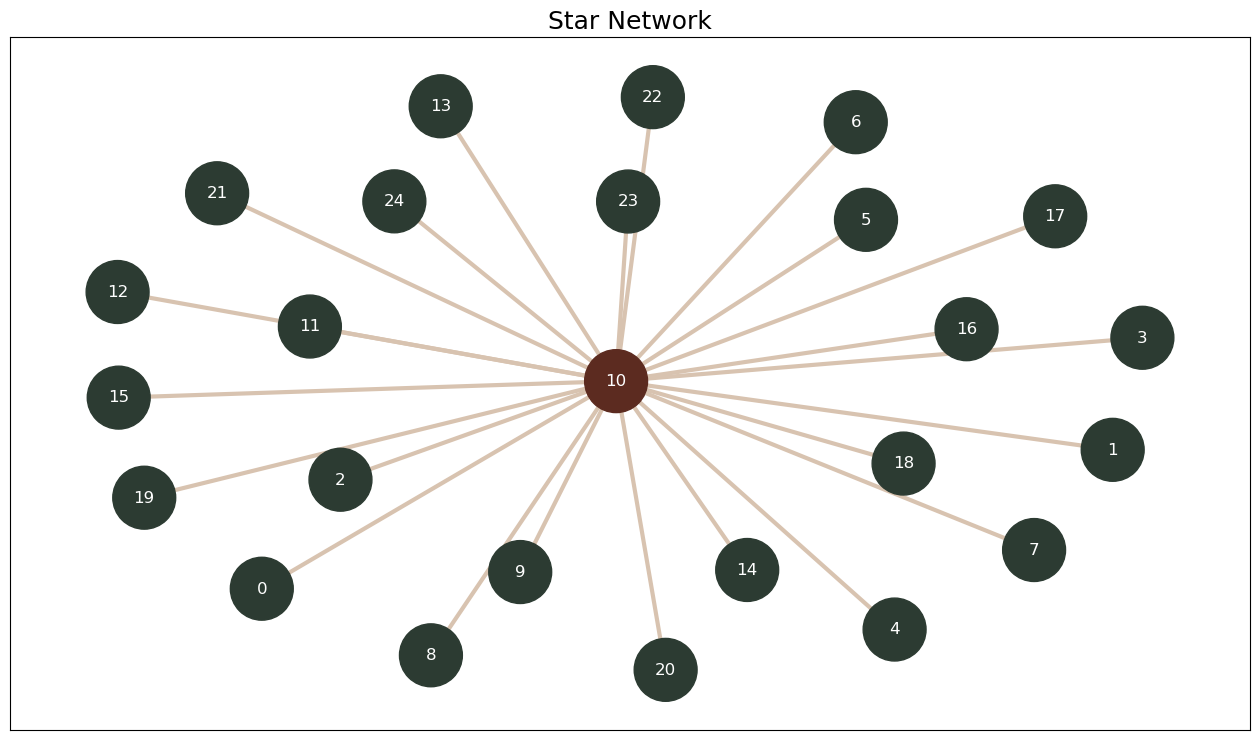

In [44]:
draw_ligand_network(network=radial_network, title=radial_network.name);

## Starry Sky Network Layout

In [45]:
from konnektor.network_planners import StarrySkyNetworkGenerator

ligand_network_planner = StarrySkyNetworkGenerator(mapper=mapper, 
                                                   scorer=scorer)

In [46]:
starry_sky_network = ligand_network_planner(components)
starry_sky_network.name="Starry Sky Network"
starry_sky_network

<LigandNetwork-d168233645d57d36645b529028f51e4a>

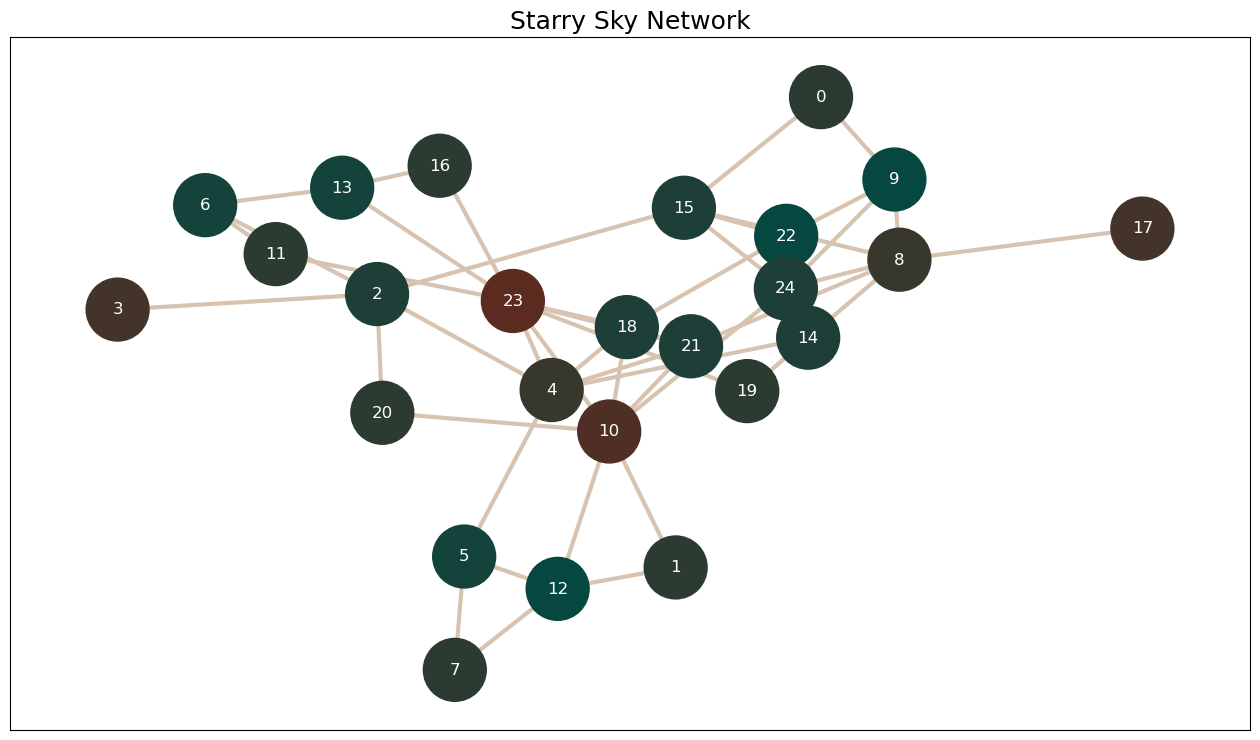

In [47]:
draw_ligand_network(network=starry_sky_network, title=starry_sky_network.name);

# NEdges Node Network

In [48]:
from konnektor.network_planners import NNodeEdgesNetworkGenerator

ligand_network_planner = NNodeEdgesNetworkGenerator(mapper=mapper, scorer=scorer)


In [49]:
nedges_network = ligand_network_planner(components)
nedges_network.name="NEdges Network"
nedges_network

<LigandNetwork-38f58389d1ef722c6c0f74c5e77c89c7>

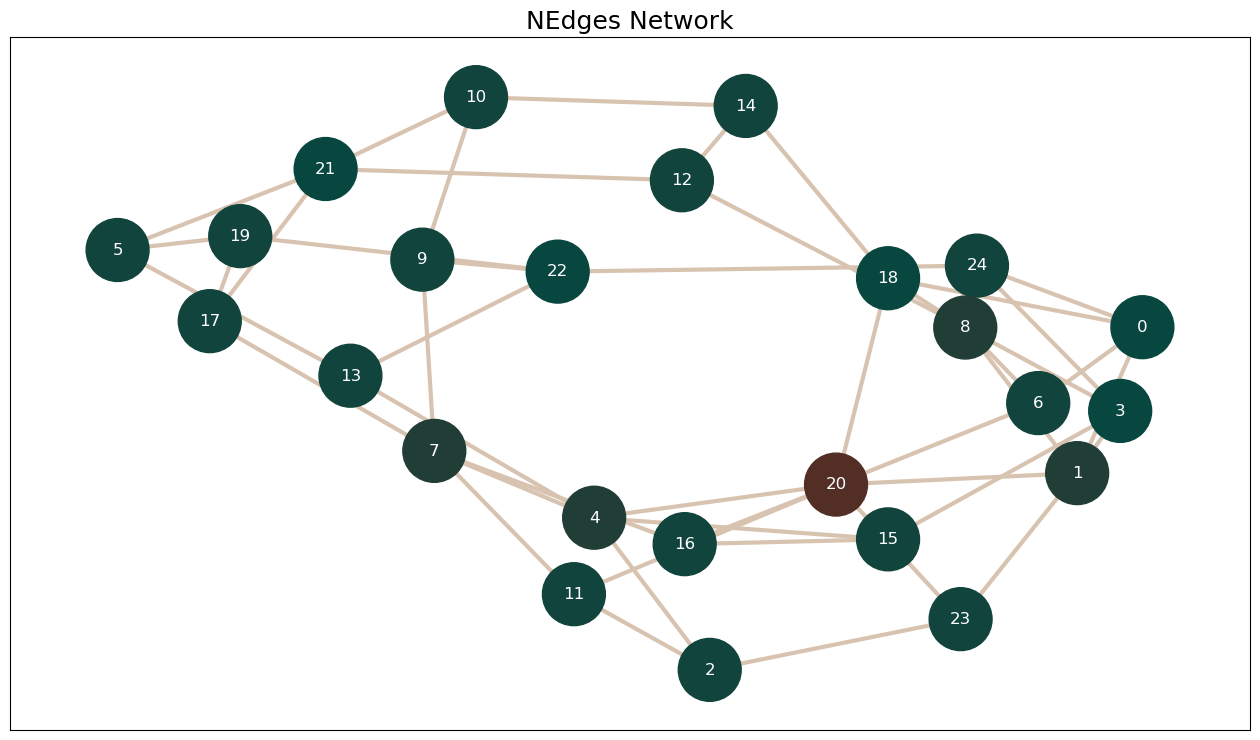

In [50]:
draw_ligand_network(network=nedges_network, title=nedges_network.name);

# Minimal Spanning Tree

In [51]:
from konnektor.network_planners import MinimalSpanningTreeNetworkGenerator

ligand_network_planner = MinimalSpanningTreeNetworkGenerator(mapper=mapper, scorer=scorer)


In [52]:
mst_network = ligand_network_planner(components)
mst_network.name="Min Spanning Tree Network"
mst_network

<LigandNetwork-d0638a326f1168a403b325a43067f820>

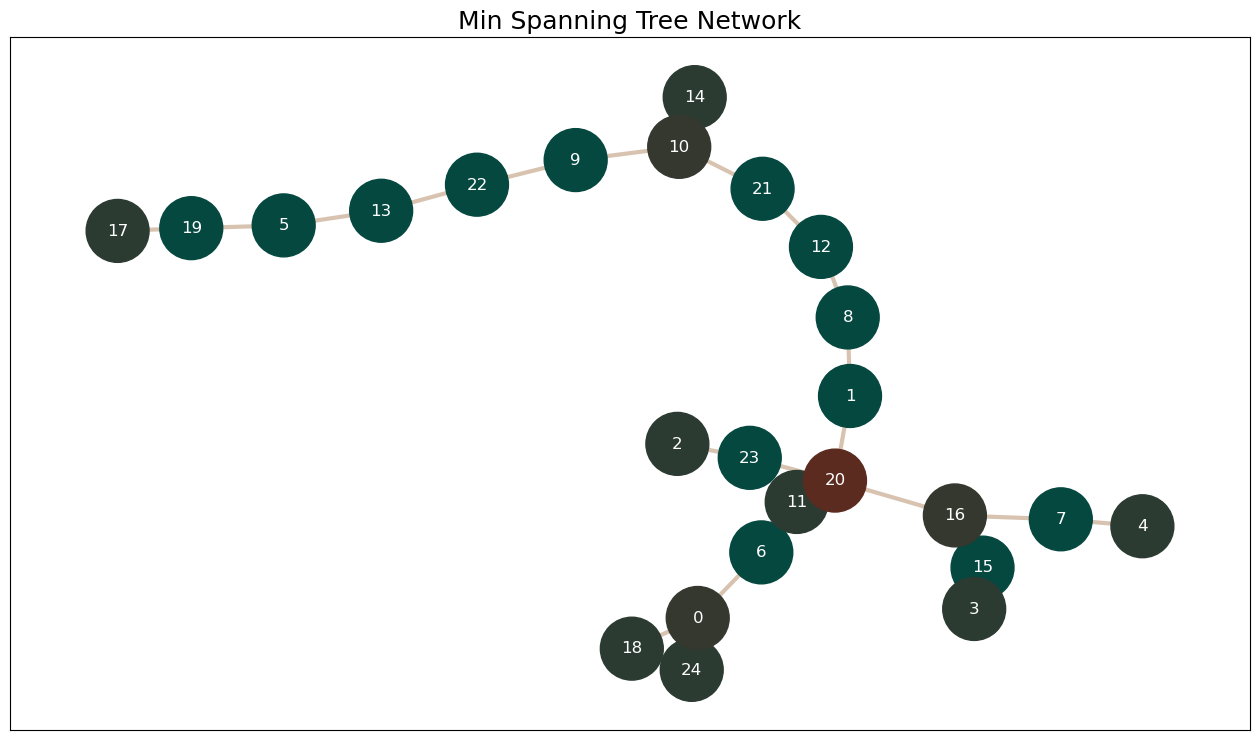

In [53]:
draw_ligand_network(network=mst_network, title=mst_network.name);

# Redundant MST

In [54]:
from konnektor.network_planners import RedundantMinimalSpanningTreeNetworkGenerator

ligand_network_planner = (RedundantMinimalSpanningTreeNetworkGenerator
                          (mapper=mapper, scorer=scorer,
                           n_redundancy=2))


In [55]:
rmst_network = ligand_network_planner(components)
rmst_network.name="Redundant Min Spanning Tree Network"
rmst_network

<LigandNetwork-2776c65a8e5de22ce65651bed9db4c7d>

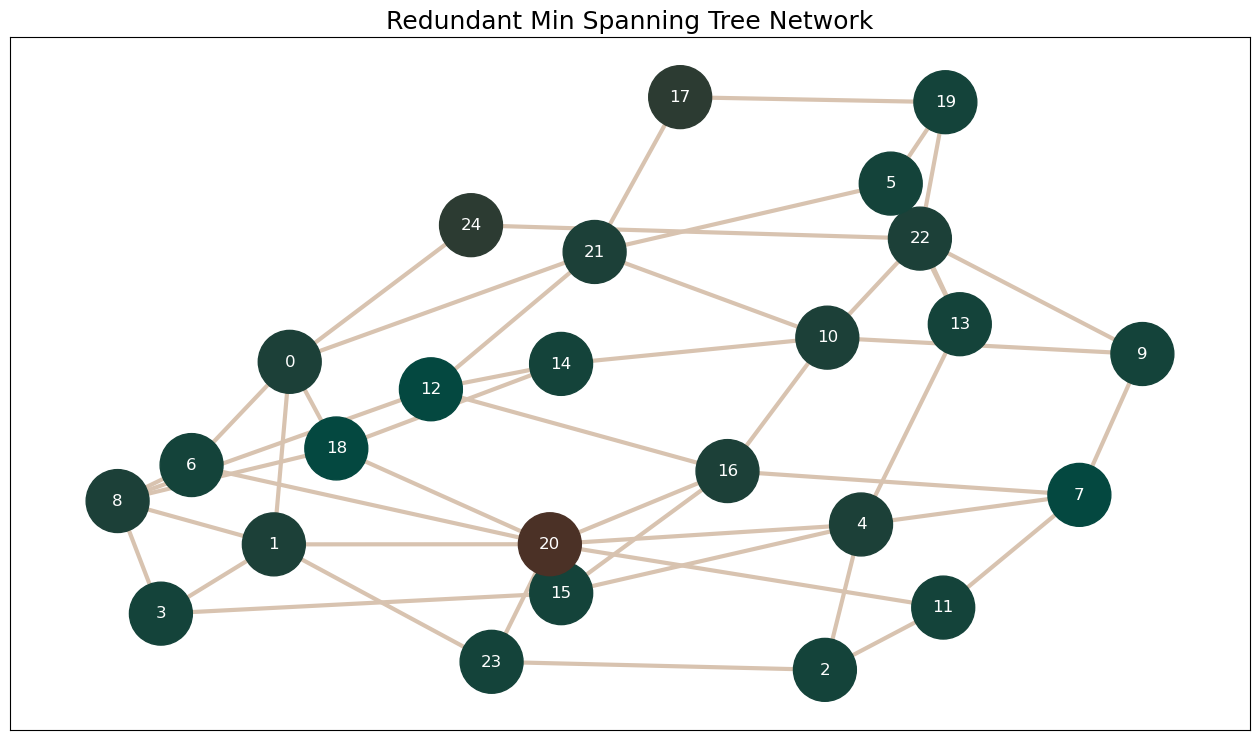

In [56]:
draw_ligand_network(network=rmst_network, title=rmst_network.name);

# Cyclo Graphs

In [57]:
from konnektor.network_planners import CyclicNetworkGenerator
ligand_network_planner = CyclicNetworkGenerator(mapper=mapper, scorer=scorer,
                                                    cycle_sizes=3, node_present_in_cycles=2)

In [58]:
cyclic_network = ligand_network_planner.generate_ligand_network(components)
cyclic_network.name="Cyclic Network"
cyclic_network

<LigandNetwork-b1a53df84eadfb57a88a34b4767a0b89>

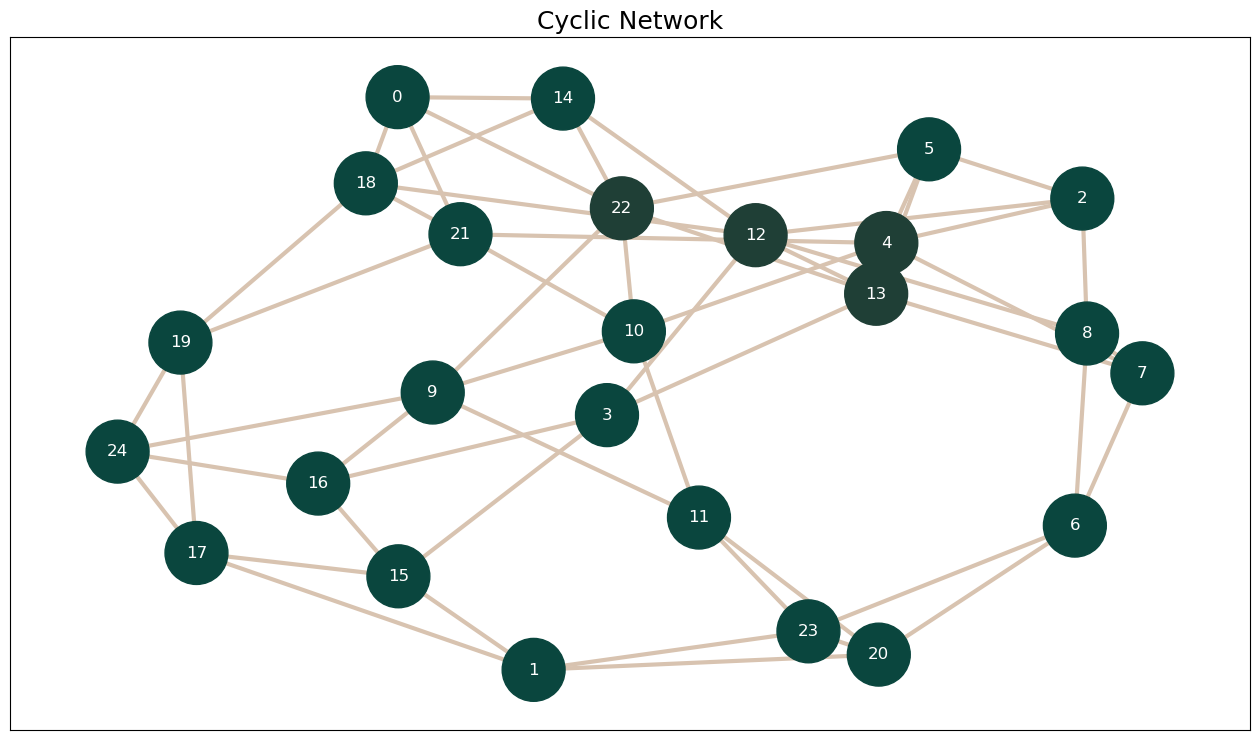

In [59]:
draw_ligand_network(network=cyclic_network, title=cyclic_network.name);

# Maximally connected network

In [60]:
import logging
from konnektor.network_planners import MaximalNetworkGenerator
from kartograf.atom_mapper import logger
logger.setLevel(logging.ERROR)

ligand_network_planner = MaximalNetworkGenerator(mapper=mapper, scorer=scorer, n_processes=3)

In [61]:
max_network = ligand_network_planner(components)
max_network.name = "Maximal Network"
max_network

<LigandNetwork-ec7a9759ec2dffda5f36600411bf620c>

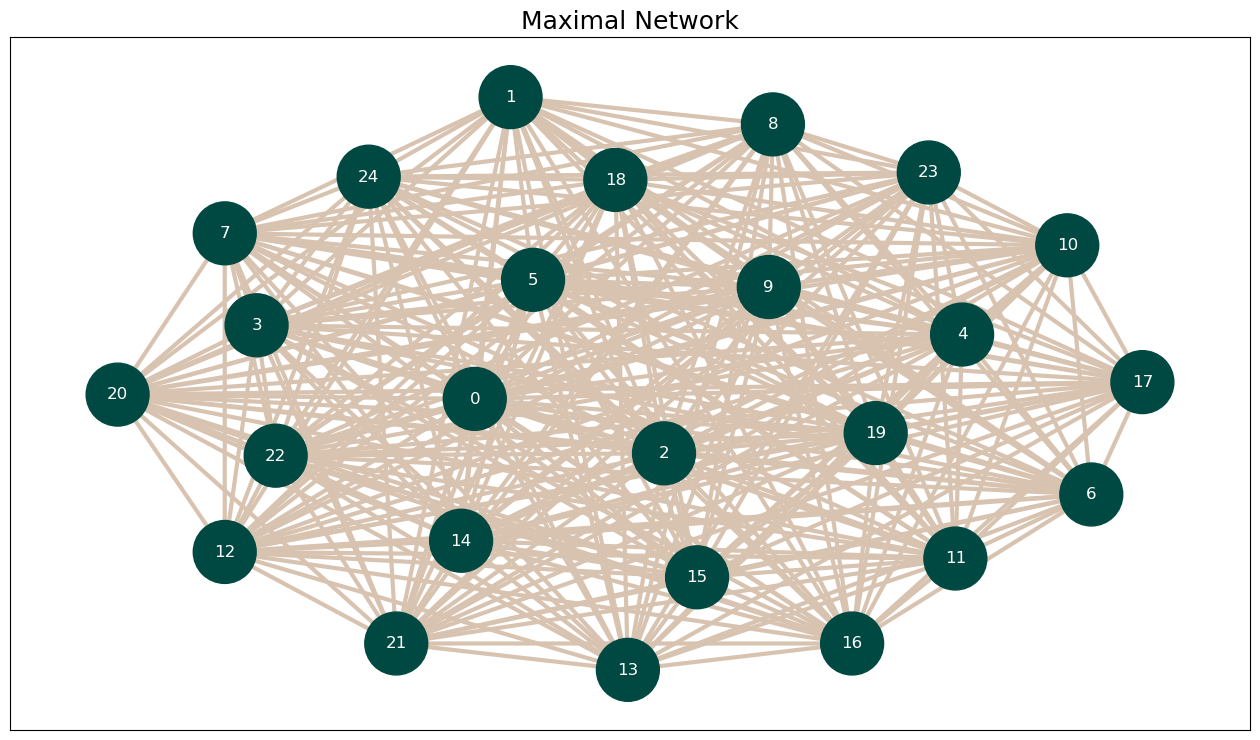

In [62]:
draw_ligand_network(network=max_network, title=max_network.name);

# Diversity Cluster Network

In [63]:
from konnektor.network_planners import ClusteredNetworkGenerator
from konnektor.network_planners import CyclicNetworkGenerator
from konnektor.network_planners import MstConcatenator

sub_network_planner = CyclicNetworkGenerator(mapper=mapper, scorer=scorer)
network_concatenator = MstConcatenator(mapper=mapper, scorer=scorer)
ligand_network_planner = ClusteredNetworkGenerator(sub_network_planners=sub_network_planner, concatenator=network_concatenator)

In [64]:
div_network = ligand_network_planner(components)
div_network.name = "Diversity Clustering Network"
div_network

ERR a cycle can not be larger, than the number of nodes.


<LigandNetwork-594808eb1d07f28acab040684a941471>

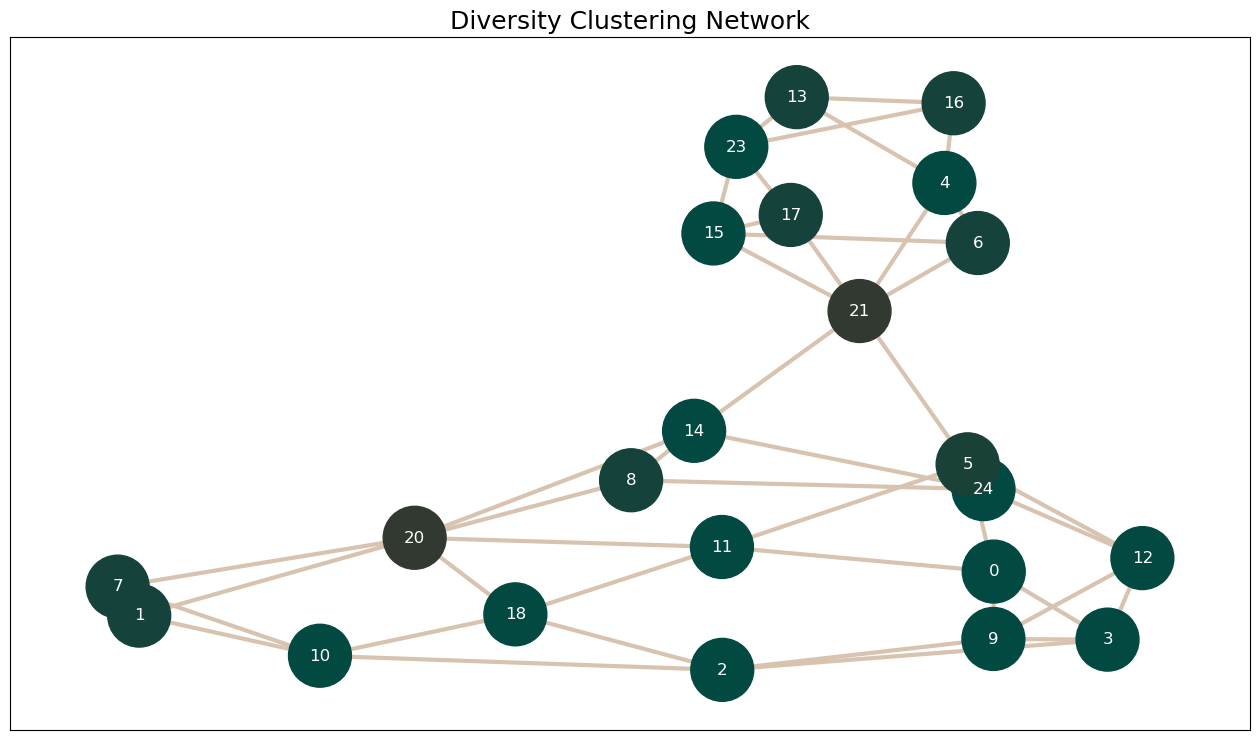

In [65]:
draw_ligand_network(network=div_network, title=div_network.name);

# Summary

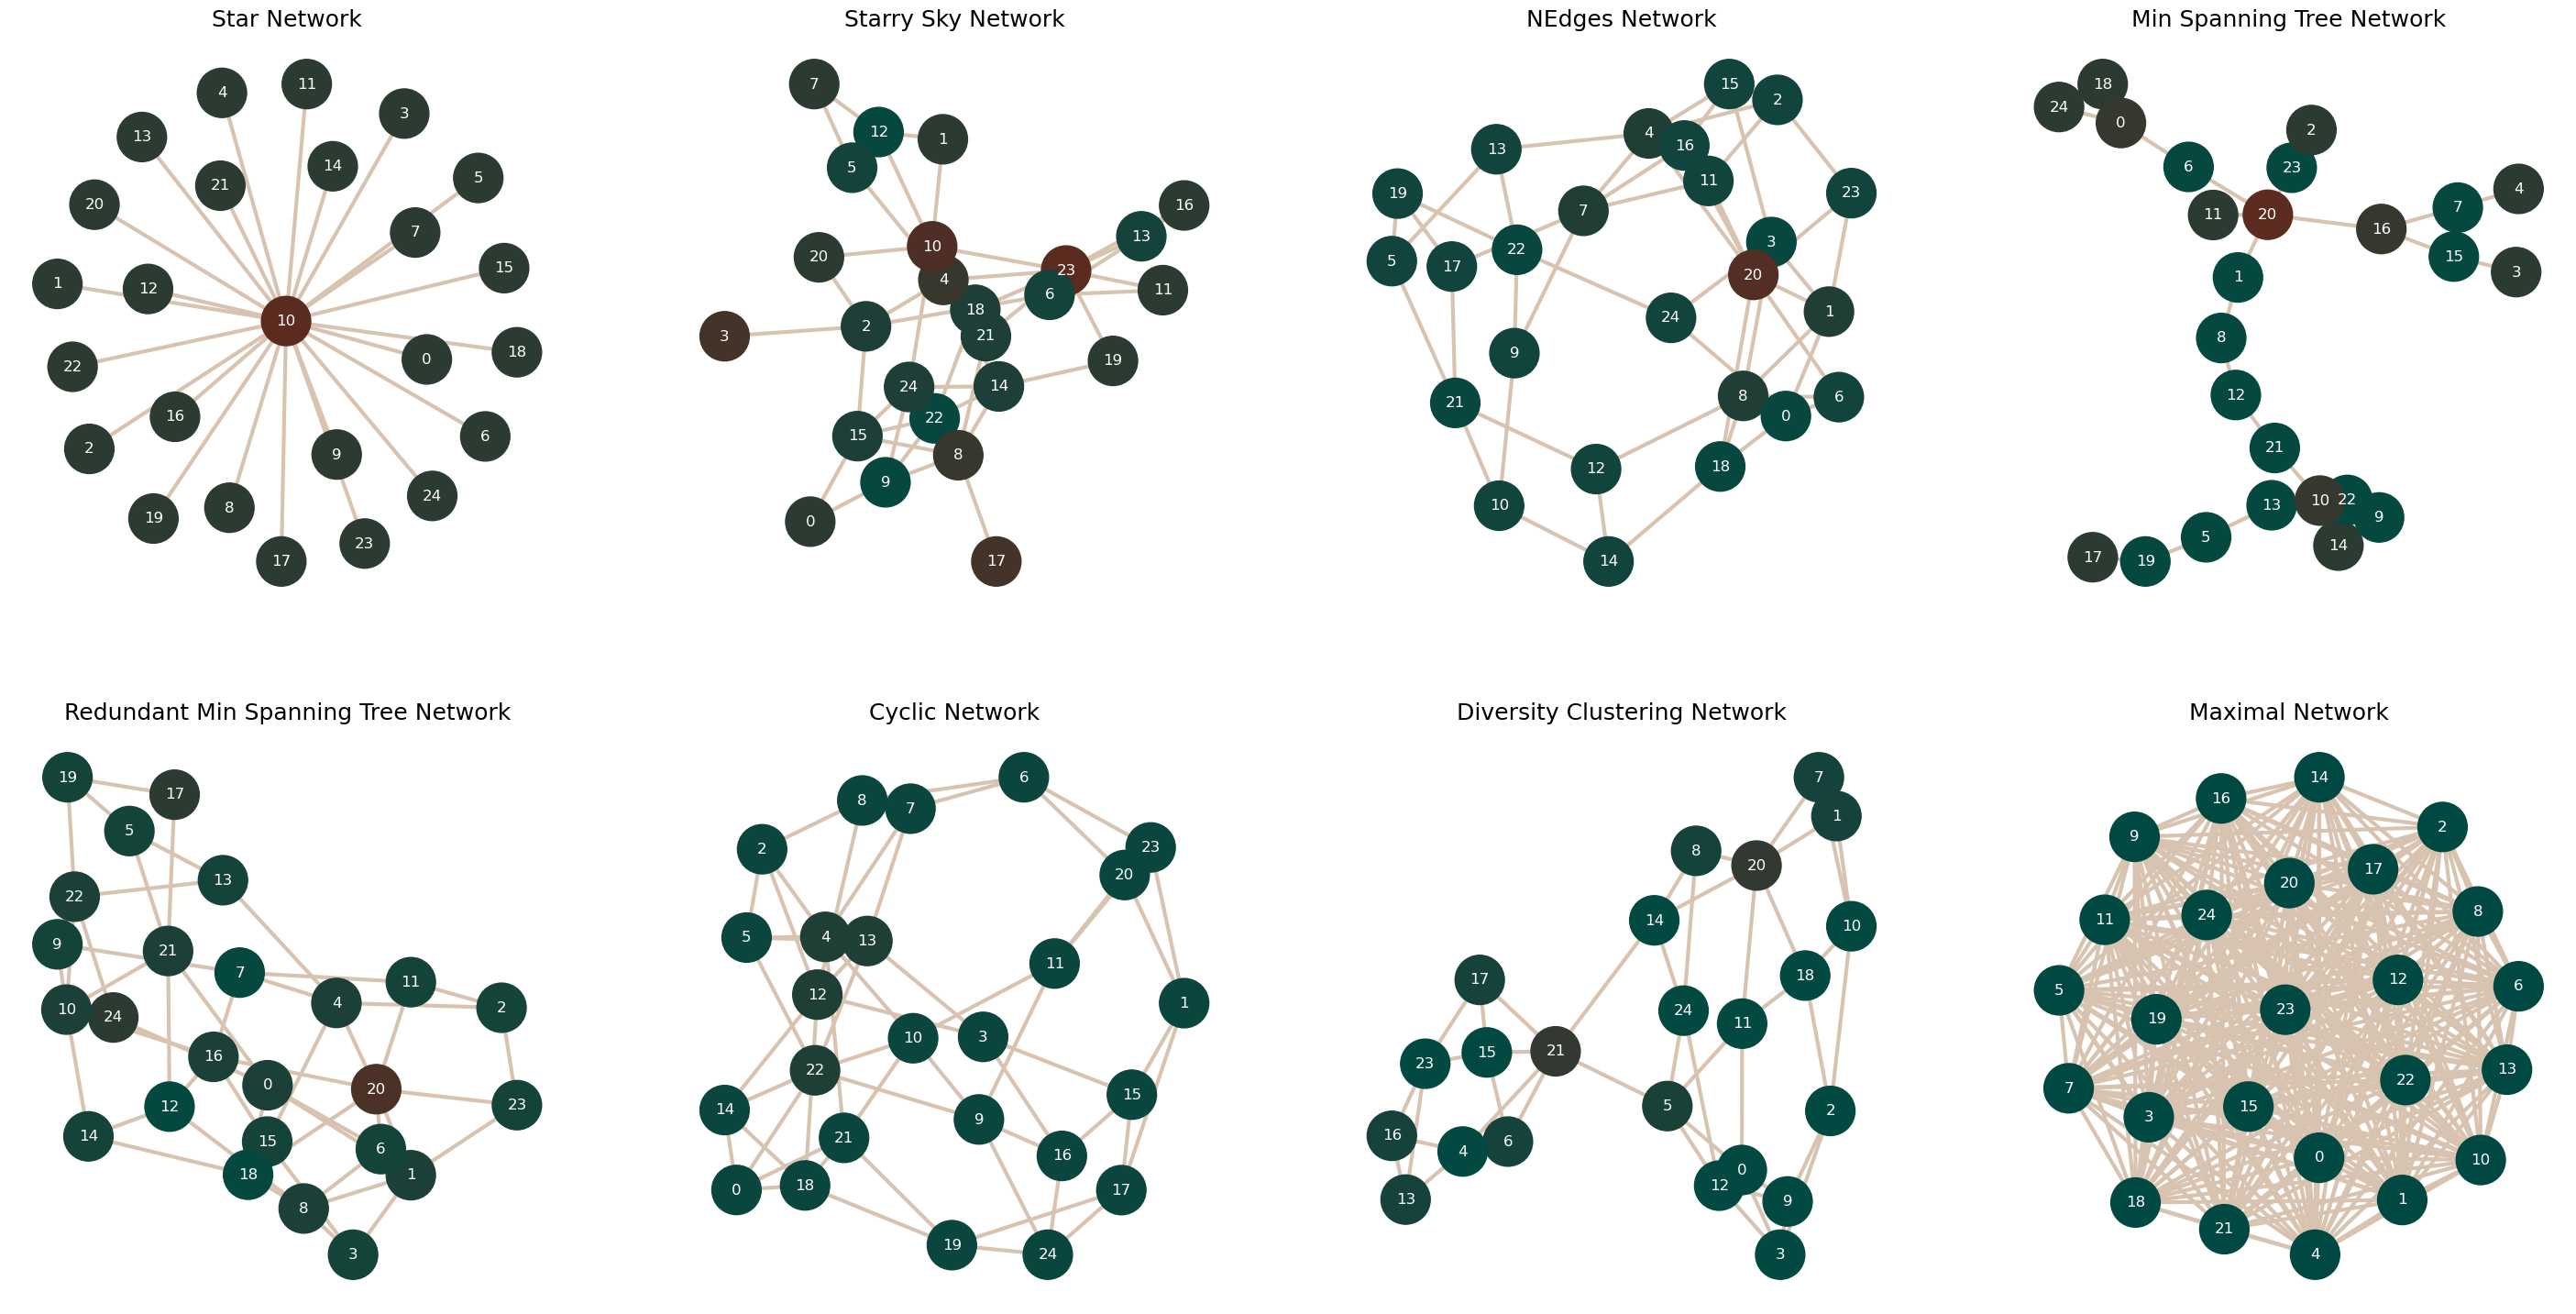

In [66]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=[9*4,2*9])
axes= np.array(axes).flat

fs = 22
for ax, net in zip(axes, [radial_network, starry_sky_network,  nedges_network,
                          mst_network, rmst_network,
                          cyclic_network, div_network,
                          max_network]):
    draw_ligand_network(network=net, title=net.name, ax=ax, node_size=1500)
    ax.axis("off")
axes[-1].axis("off");


In [67]:
# NBVAL_SKIP
fig.savefig("../.img/network_layouts.png", dpi=400)